In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

C:\Users\realc\OneDrive\Documents\GSOC


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist = datasets.MNIST(root="mnist", train=True, download=False, transform=transform)
print("Loaded MNIST:", len(mnist), "samples")

Loaded MNIST: 60000 samples


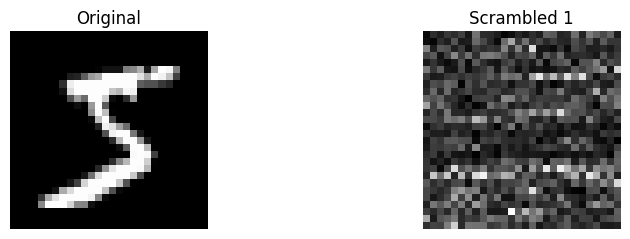

In [3]:
from utils.haar_noising_script import fast_haar_scramble
from utils.angle_encoding_script import angle_encoding
import numpy as np


def pad_to_power_of_two(vec, n_qubits):
    dim = 2 ** n_qubits
    v = np.copy(vec)
    if len(v) < dim:
        v = np.pad(v, (0, dim - len(v)), mode='constant')
    else:
        v = v[:dim]
    # normalize to unit norm
    v = v / np.linalg.norm(v)
    return v


def generate_scrambled_dataset(
    data,
    num_samples=10,
    num_scrambles=4,
    n_qubits=8,
    depth=8,
    seed=42,
    shared_unitaries=True
):
    rng = np.random.default_rng(seed)
    encoded_images = []
    scrambled_versions_all = []

    if shared_unitaries:
        print(f"Generating a set of {num_scrambles} unitaries")
        shared_scramblers = [
            lambda v, s=rng.integers(0, 1e6): fast_haar_scramble(v, n_qubits=n_qubits, depth=depth, seed=int(s))
            for _ in range(num_scrambles)
        ]
    else:
        shared_scramblers = None

    # Process samples
    for s in range(num_samples):
        encoded = angle_encoding(data, sample=s)
        encoded_images.append(encoded)

        flat_encoded = pad_to_power_of_two(encoded.flatten(), n_qubits)

        if shared_unitaries:
            scrambles = [scr(flat_encoded) for scr in shared_scramblers]
        else:
            scrambles = [
                fast_haar_scramble(flat_encoded, n_qubits=n_qubits, depth=depth, seed=seed + s * num_scrambles + k)
                for k in range(num_scrambles)
            ]

        scrambled_versions_all.append(scrambles)

    total_generated = num_scrambles if shared_unitaries else num_samples * num_scrambles

    return encoded_images, scrambled_versions_all


In [ ]:
num_samples = 100
num_scrambles = 1
n_qubits = 10
depth = 2
seed = 42

mnist_chunk = np.array([mnist[i][0].squeeze() for i in range(num_samples)])

# Record for each sample and each scramble the seed used so we can condition on it
encoded_images, scrambled_versions_all = generate_scrambled_dataset(
    mnist_chunk,
    num_samples=num_samples,
    num_scrambles=num_scrambles,
    n_qubits=n_qubits,
    depth=depth,
    seed=seed,
    shared_unitaries=False
)

# Build a parallel list of seeds/ids: here generate deterministic ids matching generate_scrambled_dataset
# We assume generate_scrambled_dataset used the per-sample seed pattern:
scramble_id_per_sample = []
for s in range(num_samples):
    ids = []
    for k in range(num_scrambles):
        ids.append(int(seed + s * num_scrambles + k))
    scramble_id_per_sample.append(ids)


In [ ]:
# Build many-to-one dataset
scrambled_flat = []
targets_flat = []
scramble_idx_flat = []
input_dim = np.prod(np.array(encoded_images).shape[1:])               # 14*14*4 = 784

for i in range(num_samples):
    for j in range(num_scrambles):
        scrambled = np.abs(scrambled_versions_all[i][j][:input_dim])  # trim/pad to match
        scrambled_flat.append(scrambled)
        targets_flat.append(encoded_images[i].flatten())

        # use the seed integer as the unitary id
        scramble_seed = scramble_id_per_sample[i][j]
        scramble_idx_flat.append(scramble_seed)

scrambled_flat = np.array(scrambled_flat)            # shape (N*num_scrambles, input_dim)
targets_flat = np.array(targets_flat)
scramble_idx_flat = np.array(scramble_idx_flat)
print("Scrambled dataset:", scrambled_flat.shape, "Targets:", targets_flat.shape, "Scramble ids:", scramble_idx_flat.shape)

# Compress seed values into compact indices 0..U-1 for embedding lookup
unique_seeds, inverse_idx = np.unique(scramble_idx_flat, return_inverse=True)
# unique_seeds maps index -> seed, inverse_idx maps each sample -> compact idx
num_unitaries = len(unique_seeds)
print("Unique unitary count:", num_unitaries)


Scrambled dataset: (100, 784) Targets: (100, 784) Scramble ids: (100,)
Unique unitary count: 100


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 16

# Split keeping scramble indices aligned
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    scrambled_flat, targets_flat, inverse_idx, test_size=0.15, random_state=seed
)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train, y_train, idx_train, test_size=0.1, random_state=seed
)

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
    torch.tensor(idx_train, dtype=torch.long),
), batch_size=batch_size, shuffle=True)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32),
    torch.tensor(idx_val, dtype=torch.long),
), batch_size=batch_size, shuffle=False)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32),
    torch.tensor(idx_test, dtype=torch.long),
), batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
import torch
from utils.quantum_diffusion import QuantumDiffusionModel

n_qubits = 8
n_layers = 2
hidden_dim = 128
num_epochs = 5
lr = 1e-3

class ConditionedQD(nn.Module):
    def __init__(self, base_model, num_unitaries, input_dim, embed_dim=64):
        super().__init__()
        self.base = base_model
        self.embed = nn.Embedding(num_unitaries, embed_dim)
        # project embedding to input_dim and add as bias
        self.project = nn.Linear(embed_dim, input_dim)
        # optional small prefix nonlinearity
        self.act = nn.Tanh()

    def forward(self, x, unitary_idx):
        """
        x: (batch, input_dim)
        unitary_idx: (batch,) long tensor, indices into embedding
        """
        e = self.embed(unitary_idx)                       # (batch, embed_dim)
        delta = self.project(e)                           # (batch, input_dim)
        delta = self.act(delta)                           # optional (keeps values bounded)
        x_cond = x + delta                                # conditioned input
        out = self.base(x_cond)                           # forward through your quantum model
        return out

device = torch.device("cpu")

base_model = QuantumDiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=input_dim,
                                   n_qubits=n_qubits, n_layers=n_layers).to(device)

# wrapper with conditioning
embed_dim = 64
cond_model = ConditionedQD(base_model, num_unitaries=num_unitaries, input_dim=input_dim, embed_dim=embed_dim).to(device)

criterion = torch.nn.MSELoss()   # or FidelityLoss if you used that earlier
optimizer = torch.optim.Adam(cond_model.parameters(), lr=lr)


In [15]:
for epoch in range(num_epochs):
    cond_model.train()
    total_loss = 0
    for xb, yb, idxb in train_loader:
        xb, yb, idxb = xb.to(device), yb.to(device), idxb.to(device)
        optimizer.zero_grad()
        out = cond_model(xb, idxb)          # pass unitary index here
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)

    # validation — similar but no grads
    cond_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, idxb in val_loader:
            xb, yb, idxb = xb.to(device), yb.to(device), idxb.to(device)
            val_loss += criterion(cond_model(xb, idxb), yb).item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f}")


Epoch 1/5 - Train: 0.95380 | Val: 0.96154
Epoch 2/5 - Train: 0.94545 | Val: 0.95826
Epoch 3/5 - Train: 0.93841 | Val: 0.95495
Epoch 4/5 - Train: 0.93171 | Val: 0.95186
Epoch 5/5 - Train: 0.92529 | Val: 0.94885



FID: 745.2746, SSIM: 0.0003


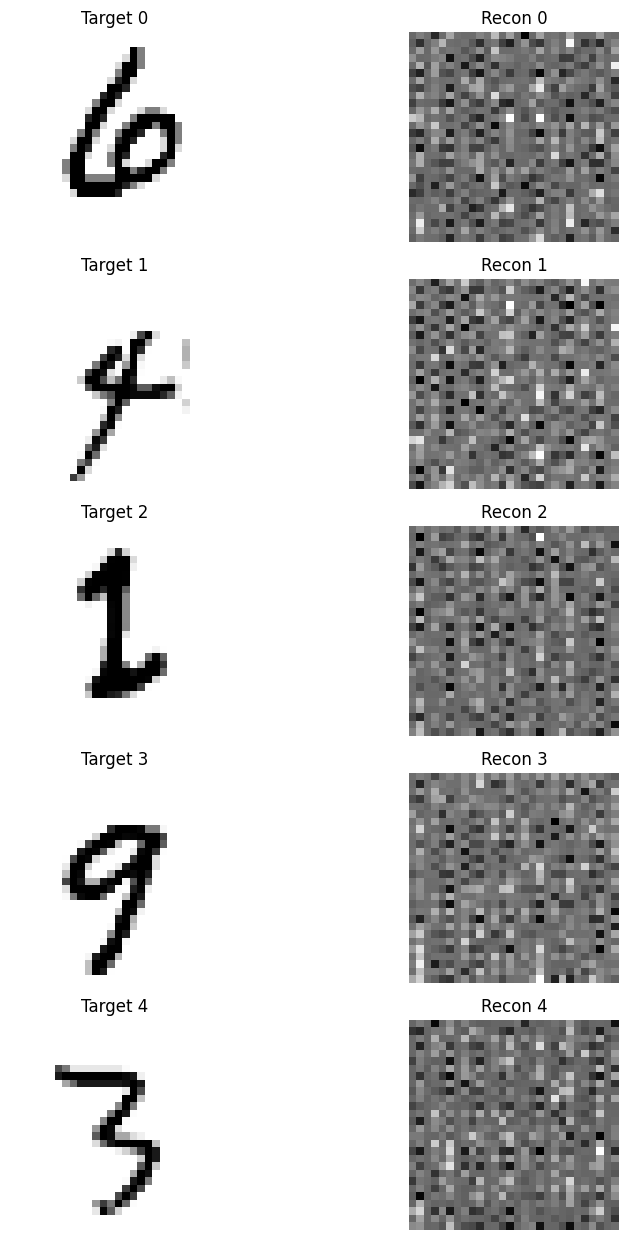

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 100

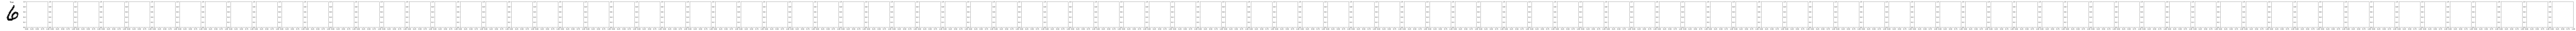

In [ ]:
from utils.statistics import *
from utils.quantum_diffusion import calculate_ssim

def decode_to_28x28(flat_batch):
    """Decode 14x14x4 back to 28x28 grayscale."""
    B = flat_batch.shape[0]
    patches = flat_batch.reshape(B, 14, 14, 4)
    decoded = np.zeros((B, 28, 28))
    for n in range(B):
        for i in range(14):
            for j in range(14):
                c0, c1, c2, c3 = patches[n, i, j]
                decoded[n, 2*i, 2*j]     = c0
                decoded[n, 2*i, 2*j+1]   = c1
                decoded[n, 2*i+1, 2*j]   = c2
                decoded[n, 2*i+1, 2*j+1] = c3
    return decoded


cond_model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb, idxb in test_loader:
        xb, yb, idxb = xb.to(device), yb.to(device), idxb.to(device)
        out = cond_model(xb, idxb).cpu().numpy()
        all_preds.append(out)
        all_true.append(yb.numpy())

all_preds = np.vstack(all_preds)
all_true = np.vstack(all_true)

decoded_preds = decode_to_28x28(all_preds)
decoded_true = decode_to_28x28(all_true)

mu_real, sigma_real = calculate_statistics(decoded_true)
mu_fake, sigma_fake = calculate_statistics(decoded_preds)
fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
ssim_score = calculate_ssim(decoded_true, decoded_preds)
print(f"\nFID: {fid_score:.4f}, SSIM: {ssim_score:.4f}")

n_show = min(5, len(decoded_preds))
plt.figure(figsize=(10, 2.5*n_show))
for i in range(n_show):
    plt.subplot(n_show, 2, 2*i + 1)
    plt.imshow(decoded_true[i], cmap='gray')
    plt.title(f"Target {i}")
    plt.axis("off")

    plt.subplot(n_show, 2, 2*i + 2)
    plt.imshow(decoded_preds[i], cmap='gray')
    plt.title(f"Recon {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()